In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sb

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import os
import glob
from bs4 import BeautifulSoup


Get the data set

In [2]:
curr_directory = os.getcwd()
train_img_path = curr_directory + "\\train\\"
test_img_path = curr_directory + "\\test\\"
files_train = [f for f in glob.glob(train_img_path + "*.jpg", recursive = True)]
files_test = [f for f in glob.glob(test_img_path + "*.jpg", recursive = True)]
files_train_xml = [f for f in glob.glob(train_img_path + "*.xml", recursive = True)]
files_test_xml = [f for f in glob.glob(test_img_path + "*.xml", recursive = True)]

In [3]:
def PreProcessXML(files):

    data_crop_xml = []
    for file in files:
        with open(file) as f:
            data = f.read()

        Bs_data = BeautifulSoup(data, "xml")

        x_min = min([int(item.get_text()) for item in Bs_data.find_all('xmin')])
        x_max = max([int(item.get_text()) for item in Bs_data.find_all('xmax')])
        y_min = min([int(item.get_text()) for item in Bs_data.find_all('ymin')])
        y_max = max([int(item.get_text()) for item in Bs_data.find_all('ymax')])

        x_y_data = [x_min,y_max,x_max,y_min]
        data_crop_xml.append(x_y_data)

    return data_crop_xml

data_train_crop_xml = PreProcessXML(files_train_xml)
data_test_crop_xml = PreProcessXML(files_test_xml)
print(data_train_crop_xml)

[[8, 349, 331, 15], [56, 1419, 1413, 99], [1, 280, 459, 5], [43, 353, 350, 21], [105, 691, 720, 261], [318, 511, 680, 146], [643, 1046, 1396, 364], [14, 300, 270, 44], [113, 700, 583, 258], [144, 411, 470, 136], [158, 1143, 1264, 116], [37, 222, 205, 52], [23, 497, 458, 55], [97, 385, 594, 112], [136, 628, 569, 199], [99, 412, 404, 131], [1, 1551, 913, 1], [167, 201, 346, 29], [125, 221, 302, 58], [51, 350, 414, 3], [25, 297, 275, 42], [43, 234, 220, 67], [176, 708, 907, 17], [1, 716, 800, 63], [3, 439, 773, 40], [553, 868, 1232, 120], [91, 706, 710, 92], [43, 324, 219, 135], [8, 161, 155, 17], [36, 334, 323, 48], [38, 1184, 1017, 189], [196, 666, 575, 317], [18, 210, 315, 22], [202, 314, 470, 37], [144, 257, 337, 55], [39, 474, 445, 55], [204, 596, 624, 154], [21, 315, 319, 27], [34, 424, 575, 62], [10, 569, 748, 22], [54, 624, 960, 72], [133, 595, 725, 115], [15, 291, 255, 87], [68, 306, 541, 1], [46, 217, 288, 40], [43, 250, 229, 68], [1, 435, 463, 72], [45, 261, 252, 53], [87, 868,

In [4]:
tiny_image_size_x = 64
tiny_image_size_y = 64
number_of_labels = 4
def PreProcess(files, istrain):
    x_res = None
    y_res = []

    for i in range(0, len(files)):
        img_raw = Image.open(files[i])
        # width,height = img_raw.size
        if istrain :
            img_raw = img_raw.crop((data_train_crop_xml[i][0],data_train_crop_xml[i][3],data_train_crop_xml[i][2],data_train_crop_xml[i][1]))
        else:
            img_raw = img_raw.crop((data_test_crop_xml[i][0],data_test_crop_xml[i][3],data_test_crop_xml[i][2],data_test_crop_xml[i][1]))
        img_tiny = img_raw.resize((tiny_image_size_x,tiny_image_size_y))
        if img_tiny.mode == 'RGBA' or img_tiny.mode == 'P':
            img_tiny = img_tiny.convert('RGB')
        if x_res is None:
            x_res = img_tiny
        else:
            x_res = np.concatenate((x_res, img_tiny))
        y_res.append(os.path.basename(files[i]).split('_')[0])
#        if istrain:
#             angle = 90
#             inc = 3
#             for j in range(inc):
#                    new_angle = (j+1)*angle
#                    new_img = img_tiny.rotate(new_angle)
#                    x_res = np.concatenate((x_res, new_img))
#                    y_res.append(os.path.basename(files[i]).split('_')[0])

    x_res = x_res.reshape(-1, tiny_image_size_x, tiny_image_size_y, 3)
    le = LabelEncoder()
    le.fit(y_res)
    y_res = le.transform(y_res)
    y_res = tf.keras.utils.to_categorical(y_res, number_of_labels)
    # print(le.classes_)
    # print(y_res)
    return x_res , y_res

x_train,y_train = PreProcess(files_train,True)
x_test,y_test = PreProcess(files_test,False)

C:\Users\manas\anaconda3\envs\pythonProject\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


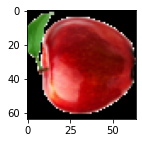

In [5]:
img2 = Image.fromarray(x_train[1])

plt.subplots(figsize=(2,2))
plt.imshow(img2)

In [6]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=16,
    kernel_size=(2, 2),
    activation='relu',
    input_shape=(tiny_image_size_x, tiny_image_size_y, 3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=64, activation='relu'))
model.add(tf.keras.layers.Dense(units=number_of_labels, activation='softmax'))

In [7]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Train our model.

In [8]:
hist = model.fit(x=x_train/255, y=y_train, epochs=30)

Epoch 1/30
30/30 [==============================] - 0s 13ms/step - loss: 0.8803 - accuracy: 0.7229
Epoch 2/30
30/30 [==============================] - 0s 13ms/step - loss: 0.4779 - accuracy: 0.8667
Epoch 3/30
30/30 [==============================] - 0s 13ms/step - loss: 0.3388 - accuracy: 0.9083
Epoch 4/30
30/30 [==============================] - 0s 13ms/step - loss: 0.2641 - accuracy: 0.9365
Epoch 5/30
30/30 [==============================] - 0s 13ms/step - loss: 0.2125 - accuracy: 0.9594
Epoch 6/30
30/30 [==============================] - 0s 13ms/step - loss: 0.1855 - accuracy: 0.9635
Epoch 7/30
30/30 [==============================] - 0s 13ms/step - loss: 0.1639 - accuracy: 0.9708
Epoch 8/30
30/30 [==============================] - 0s 13ms/step - loss: 0.1551 - accuracy: 0.9646
Epoch 9/30
30/30 [==============================] - 0s 13ms/step - loss: 0.1471 - accuracy: 0.9708
Epoch 10/30
30/30 [==============================] - 0s 13ms/step - loss: 0.1234 - accuracy: 0.9792
Epoch 11/

In [9]:
loss, accuracy = model.evaluate(x=x_test, y=y_test)

print('loss = ', loss)
print('accuracy = ', accuracy)

2/2 [==============================] - 0s 2ms/step - loss: 95.8259 - accuracy: 0.7833
loss =  95.825927734375
accuracy =  0.7833333611488342
